# iUROP Transformer Benchmarking
This notebook is part of the effort to benchmark different contemporary object detection algorithms with respect to traffic analysis.

Benchmarking points:

- Detection Time (Computational Cost)
- Vehicle Count
- Average Confidence

https://huggingface.co/facebook/detr-resnet-50
## Import Libs

In [76]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch
from datetime import datetime
import pandas as pd
import requests
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pandas as pd

## Load Models

In [77]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

DETECTION_THRESHOLD = 0.2
NEEDED_LABELS = ["bus", "car", "truck", "motorcycle"]


def detect_object_using_transformer(image):

    start_time = datetime.now()
    # Preprocessing
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Inference
    outputs = model(**inputs)

    # Postprocessing: convert outputs (bounding boxes and class logits) to COCO API
    target_sizes = torch.tensor([image.size[::-1]])
    
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    detection_time = (datetime.now() - start_time).microseconds * 0.001 # Miliseconds

    return results, detection_time

c:\Users\f-bon\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

In [78]:
url =  "https://images.data.gov.sg/api/traffic-images/2022/04/0471f348-8b4e-4250-a002-c4117c543136.jpg"
image = Image.open(requests.get(url, stream=True).raw)
results, detection_time = detect_object(image)
print(results)
print(results['scores'])

{'scores': tensor([0.7146, 0.9772, 0.7485, 0.5815, 0.7685, 0.9913, 0.6439, 0.9937, 0.7222,
        0.9911], grad_fn=<IndexBackward0>), 'labels': tensor([8, 3, 3, 3, 3, 8, 3, 3, 3, 3]), 'boxes': tensor([[ 985.1699,  239.1395, 1029.8362,  275.1863],
        [ 689.1428,  216.8942,  712.7741,  234.1946],
        [ 719.5612,  164.7305,  738.3843,  182.0169],
        [ 706.1791,  185.2290,  723.3419,  200.3395],
        [ 710.2032,  175.0581,  728.6246,  191.1324],
        [ 458.3346,  241.8256,  503.7293,  285.5009],
        [ 704.9094,  170.5182,  722.4301,  184.6705],
        [1034.6647,  227.0389, 1075.3013,  255.4594],
        [ 713.5826,  159.7143,  731.9153,  174.6499],
        [ 983.7483,  240.6733, 1027.0216,  274.9550]],
       grad_fn=<IndexBackward0>)}
tensor([0.7146, 0.9772, 0.7485, 0.5815, 0.7685, 0.9913, 0.6439, 0.9937, 0.7222,
        0.9911], grad_fn=<IndexBackward0>)


## Benchmarking

In [79]:
bm_data = pd.read_excel('example_data.xlsx',sheet_name='in')
bm_data = bm_data[['Timestamp_sg_time','URL']]
bm_data.drop_duplicates(inplace=True)
print(bm_data.shape[0], "images are available!")

# Select a sample of images:
n_randoms_images = 3
rand_images = bm_data.sample(n=n_randoms_images, random_state=22)
rand_images_URL = rand_images['URL'].to_list()
rand_images_time = rand_images['Timestamp_sg_time'].to_list()


228 images are available!


In [86]:
results = []
detection_times = []
for url in rand_images_URL:
    image = Image.open(requests.get(url, stream=True).raw)
    result, detection_time = detect_object_using_transformer(image)
    results.append(result)
    detection_times.append(detection_time)

def benchmark_summary_transformer(results, model, detection_time, data_source, data_time): 

    benchmark_results_transformer = pd.DataFrame(columns=['URL',
                                                   'TIME_SG',
                                                   'DETECTION_TIME',
                                                   'CAR_COUNT', 
                                                   'CAR_AVG_CONF',
                                                   'CAR_BOXES',
                                                   'MOTOR_CYCLE_COUNT',
                                                   'MC_AVG_CONF',
                                                   'MC_BOXES',
                                                   'BUS_COUNT',
                                                   'BUS_AVG_CONF',
                                                   'BUS_BOXES'
                                                   'MC_BOXES',
                                                   'TRUCK_COUNT',
                                                   'TRUCK_AVG_CONF',
                                                   'TRUCK_BOXES']
                                                    )
    for i, result in enumerate(results):

        # Reset counts and confidence counts
        car_count = 0
        car_conf_sum = 0
        car_boxes = []
        motor_cycle_count = 0
        motor_cycle_conf_sum = 0
        mc_boxes = []
        bus_count = 0
        bus_conf_sum = 0
        bus_boxes = []
        truck_count = 0
        truck_conf_sum = 0                                                                             
        truck_boxes = []

        for score, label, boxlist in zip(result["scores"], result["labels"], result["boxes"]):

            label = model.config.id2label[label.item()]    
            # let's only keep detections with score > DETECTION_THRESHOLD
            if (score.item() > DETECTION_THRESHOLD and label in NEEDED_LABELS):
                box = [int(j) for j in boxlist.tolist()]
            print(f"Detected object with label {label} and score {score}")
            print(f"Bounding box coordinates: {box}")

            if label == 'car':
                car_count += 1
                car_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                car_boxes.append(box)
            elif label == 'truck':
                truck_count += 1
                truck_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                truck_boxes.append(box)
            elif label == 'bus':
                bus_count += 1
                bus_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                bus_boxes.append(box)
            elif label == 'motorcycle':
                motor_cycle_count += 1
                motor_cycle_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                mc_boxes.append(box)

        # Evaluate average confidence for the different classes
        print(f"Car count: {car_count}",type(car_boxes))
        car_AVG_conf = car_conf_sum / car_count if car_count != 0 else 'N/A'
        
        bus_AVG_conf = bus_conf_sum / bus_count if bus_count != 0 else 'N/A'
        
        truck_AVG_conf = truck_conf_sum / truck_count if truck_count != 0 else 'N/A'
        
        MC_AVG_conf = motor_cycle_conf_sum / motor_cycle_count if motor_cycle_count != 0 else 'N/A'
       

        row = pd.DataFrame({'URL': [data_source[i]],
                            'TIME_SG':[data_time[i]],
                            'DETECTION_TIME': [detection_time],
                            'CAR_COUNT': [car_count],
                            'CAR_AVG_CONF': [car_AVG_conf],
                            'CAR_BOXES': [car_boxes], 
                            'MOTOR_CYCLE_COUNT': [motor_cycle_count],
                            'MC_AVG_CONF': [MC_AVG_conf],
                            'MC_BOXES': [mc_boxes], 
                            'BUS_COUNT': [bus_count],
                            'BUS_AVG_CONF': [bus_AVG_conf],
                            'BUS_BOXES': [bus_boxes], 
                            'TRUCK_COUNT': [truck_count],
                            'TRUCK_AVG_CONF': [truck_AVG_conf],
                            'TRUCK_BOXES': [bus_boxes]
                            })
        
       
        benchmark_results_transformer = pd.concat([benchmark_results_transformer, row], ignore_index=True)

    return benchmark_results_transformer



summary = benchmark_summary_transformer(results = results, 
                                        model = model, 
                                        detection_time = detection_time,
                                        data_source = rand_images_URL,
                                        data_time = rand_images_time
                                        )


summary.head()

Detected object with label car and score 0.8134647011756897
Bounding box coordinates: [835, 128, 851, 141]
Detected object with label car and score 0.7500212788581848
Bounding box coordinates: [846, 127, 862, 140]
Detected object with label car and score 0.7117074728012085
Bounding box coordinates: [712, 114, 733, 132]
Detected object with label car and score 0.9919214248657227
Bounding box coordinates: [764, 255, 802, 291]
Detected object with label truck and score 0.681504487991333
Bounding box coordinates: [575, 211, 606, 234]
Detected object with label car and score 0.5646128058433533
Bounding box coordinates: [677, 126, 700, 146]
Detected object with label car and score 0.6449663639068604
Bounding box coordinates: [688, 108, 709, 123]
Detected object with label car and score 0.7671034932136536
Bounding box coordinates: [1056, 247, 1089, 266]
Detected object with label car and score 0.5681913495063782
Bounding box coordinates: [705, 119, 725, 137]
Detected object with label car and

C:\Users\f-bon\AppData\Local\Temp\ipykernel_21548\508518332.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_transformer = pd.concat([benchmark_results_transformer, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,CAR_BOXES,MOTOR_CYCLE_COUNT,MC_AVG_CONF,MC_BOXES,BUS_COUNT,BUS_AVG_CONF,BUS_BOXESMC_BOXES,TRUCK_COUNT,TRUCK_AVG_CONF,TRUCK_BOXES,BUS_BOXES
0,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 16:40:00,656.554,34,0.768823,"[[835, 128, 851, 141], [846, 127, 862, 140], [...",2,0.74904,"[[824, 352, 845, 386], [823, 339, 849, 382]]",0,N/A,NaN,5,0.792888,[],[]
1,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 18:40:00,656.554,36,0.754705,"[[782, 177, 803, 200], [73, 735, 248, 890], [6...",0,N/A,[],0,N/A,NaN,7,0.809333,[],[]
2,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 17:40:00,656.554,36,0.782545,"[[729, 117, 751, 137], [800, 109, 819, 121], [...",1,0.714575,"[[642, 246, 657, 267]]",0,N/A,NaN,6,0.802550,[],[]


In [87]:
print(rand_images_URL)

['https://images.data.gov.sg/api/traffic-images/2022/04/2d1f01af-456e-4ed2-ad27-9fe586bfedb0.jpg', 'https://images.data.gov.sg/api/traffic-images/2022/04/51c7bb17-40b4-4105-94c4-0d386328202a.jpg', 'https://images.data.gov.sg/api/traffic-images/2022/04/e1c8ffcd-1cc5-47d8-a5e4-eec6d037d1f7.jpg']


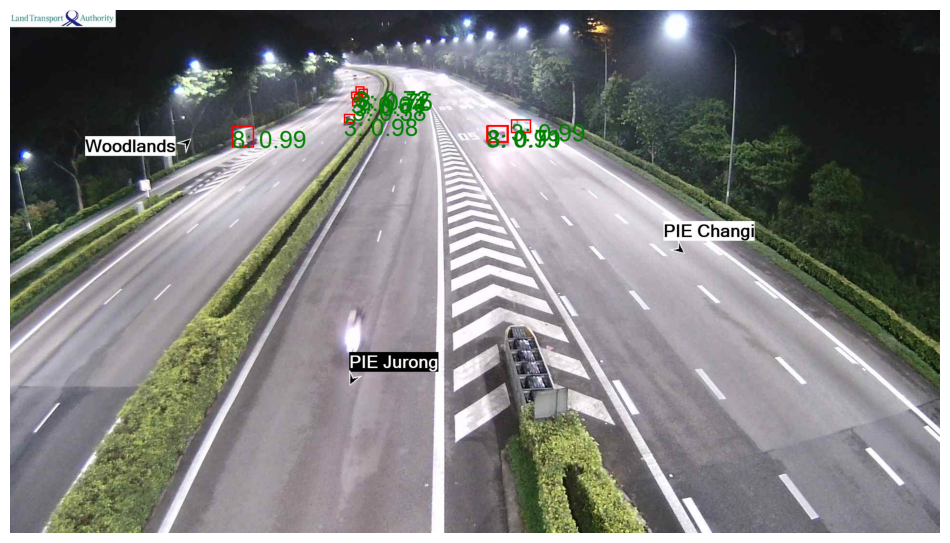

In [24]:
def visualize_detection(image, results):
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("arial.ttf", 50)  # Adjust font size as needed
    for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
        if score > 0.5:  # Adjust the threshold as needed
            box = box.tolist()
            draw.rectangle(box, outline="red", width=3)
            draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill="green", font=font)
    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    plt.imshow(image)
    plt.axis("off")
    plt.show()

visualize_detection(image, results)